### Create multifaceted plots to display human diversity in the Arivale and the Human Gut cohort

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib
import warnings
%matplotlib inline
warnings.simplefilter('ignore')
from arivale_data_interface import *
frozen_ss_path='/proj/arivale/snapshots/arivale_snapshot_ISB_2020-03-16_2156'
sn=list_snapshot_contents() #list all content
def get_frozen_snapshot(ss_name, ss_path=frozen_ss_path): #collect data
    return get_snapshot(ss_name, path=ss_path)
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

In [2]:
genpath = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome'

In [3]:
amgut=pd.read_csv(genpath+'/american_gut_cohort/alpha-diversity.csv')
amgut.sort_values(by='inv_simpson')

,Unnamed: 0.1,Unnamed: 0,simpson,inv_simpson
4422,4422,10317.000001626,0.039547,1.041175
398,398,10317.000003200,0.068887,1.073984
2055,2055,10317.000001334,0.075268,1.081394
5729,5729,10317.000037953,0.087410,1.095782
5219,5219,10317.000014173,0.124823,1.142626
...,...,...,...,...
8246,8246,10317.000017202,0.984888,66.173979
2737,2737,10317.000030077,0.985018,66.744981
1149,1149,10317.000001099,0.985057,66.922220
9095,9095,10317.000062113,0.985989,71.373104


In [4]:
######### Import, clean, and format American Gut dataset #########

# Get amgut metadata, filter, and merge with amgut data
metadata = pd.read_csv(genpath+'/american_gut_cohort/american_gut/metadata.tsv', sep = '\t', low_memory = False)\
[['sample_name','sex','height_cm', 'age_years', 'weight_kg', 'bowel_movement_frequency', 'vegetable_frequency']]

amgut=pd.read_csv(genpath+'/american_gut_cohort/alpha-diversity.csv')
amgut=amgut.rename(columns = {'Unnamed: 0':'sample_name'})
amgut=pd.merge(metadata, amgut, on ='sample_name')

#Converting values to numeric
amgut['height_cm'] = pd.to_numeric(amgut['height_cm'], errors = 'coerce')
amgut['weight_kg'] = pd.to_numeric(amgut['weight_kg'], errors='coerce')
amgut['age_years'] =  pd.to_numeric(amgut['age_years'], errors='coerce')

#Filter
amgut=amgut[amgut['age_years'] >= 18].rename(columns = {'age_years':'age'})
amgut=amgut[(amgut['height_cm'] <= 244) & (amgut['height_cm'] >= 122)]
amgut=amgut[amgut['weight_kg']<300]
        
# # Convert BMF to numeric for regressions
norm_bmf=list()
for i in range(0,len(amgut)):
    check = amgut.iloc[i,5]
    if check == 'Less than one':
        norm_bmf.append(1)
    elif check == 'One':
        norm_bmf.append(2)
    elif check == 'Two':
        norm_bmf.append(3)
    elif check == 'Three':
        norm_bmf.append(4)
    elif check == 'Four':
        norm_bmf.append(5)
    elif check=='Five or more':
        norm_bmf.append(6)
    else:
        norm_bmf.append(float('nan'))
        
amgut['bowel_movement_frequency']=norm_bmf

# Convert height from cm to inches so I can calculate the BMI 
amgut['height_in']=amgut['height_cm'].apply(lambda x: x/2.54)
amgut['weight_lb']=amgut['weight_kg'].apply(lambda x: x*2.205)
amgut['BMI_CALC']= amgut['weight_lb']/(amgut['height_in']**2)*703

# Convert sex info to binomial M and F
sexes=['female', 'male']
amgut=amgut[amgut['sex'].isin(sexes)]
amgut['sex']=amgut['sex'].apply(lambda x: 'F' if x=='female' else 'M')

# Drop individuals who don't have info on veggie frequency data
amgut=amgut[amgut['vegetable_frequency']!= 'Not provided']

high = ['Daily']
# Define veggie consumption on a binary 
amgut['b_vegetable_frequency'] = amgut['vegetable_frequency'].apply(lambda x: 'high' if x in high else 'low')

# Convert vegetable frequency to numeric for regressions 
vegetable_frequency=list()
for i in range(0,len(amgut)):
    check = amgut.iloc[i,6]
    if check == 'Never':
        vegetable_frequency.append(1) # start at 0 like the Arivale dataset
    elif check == 'Rarely (less than once/week)':
        vegetable_frequency.append(2)
    elif check == 'Occasionally (1-2 times/week)':
        vegetable_frequency.append(3)
    elif check == 'Regularly (3-5 times/week)':
        vegetable_frequency.append(4)
    elif check == 'Daily':
        vegetable_frequency.append(5)
    else:
        vegetable_frequency.append(float('nan'))
amgut['vegetable_frequency'] = vegetable_frequency


amgut.head()

,sample_name,sex,height_cm,age,weight_kg,bowel_movement_frequency,vegetable_frequency,Unnamed: 0.1,simpson,inv_simpson,height_in,weight_lb,BMI_CALC,b_vegetable_frequency
0,10317.000001000,F,154.0,64.0,52.0,3.0,5,4350,0.845933,6.490674,60.629921,114.660,21.927709,high
11,10317.000001031,M,178.0,64.0,56.0,3.0,4,7313,0.814207,5.382326,70.078740,123.480,17.675812,low
14,10317.000001041,F,162.0,59.0,61.0,2.0,5,9216,0.872256,7.828156,63.779528,134.505,23.245086,high
60,10317.000001166,F,172.0,47.0,74.0,4.0,3,5257,0.909821,11.089110,67.716535,163.170,25.015327,low
62,10317.000001171,F,167.0,68.0,68.0,5.0,5,4597,0.948946,19.587073,65.748031,149.940,24.384133,high


In [5]:
######### Import, clean, and format Arivale dataset #########

arivale=pd.read_csv(genpath+'/arivale_cohort/alpha-diversity.csv').rename(columns={'Unnamed: 0':'id'})

# Get sample metadata and merge
metadata = pd.read_csv('/proj/arivale/microbiome/16S_processed/metadata.csv')[['public_client_id', 'id', 'days_in_program','sex', 'age']]\
                        .rename(columns = {'public_client_id':'sample_id'})


arivale = pd.merge(arivale, metadata, on = 'id')

# Get weight data and merge
weights = get_frozen_snapshot('weight')[['public_client_id', 'days_in_program', 'BMI_CALC', 'HEIGHT_CALC']]\
                     .dropna().rename(columns = {'public_client_id':'sample_id'})

arivale = pd.merge_asof(
    arivale[arivale.sample_id.isin(weights.sample_id)].sort_values(by='days_in_program'),
    weights.sort_values(by='days_in_program'), 
    by = 'sample_id', on = 'days_in_program', direction='nearest')

# convert height from in to cm 
arivale['height_cm']=arivale['HEIGHT_CALC'].apply(lambda x: x*2.54)

# Finally, I need bowel movement frequency 
digestion = get_frozen_snapshot('assessments_digestive_health')[['public_client_id', 'days_in_program', 'assessment:digestion:bowel-movements:enum']].dropna().rename(columns = {'public_client_id':'sample_id'})

# Get the bowel movement number 
digestion['bowel_movement_frequency'] = digestion['assessment:digestion:bowel-movements:enum'].astype(str).apply(lambda x: x[1])
digestion['bowel_movement_frequency'] = digestion['bowel_movement_frequency'].astype(int)

arivale = pd.merge_asof(arivale.sort_values(by='days_in_program'),
    # arivale[arivale.sample_id.isin(arivale.sample_id)].sort_values(by='days_in_program'),
    digestion.sort_values(by='days_in_program'),
    by='sample_id', on='days_in_program', direction='nearest')

# Add in dietary data
diet=get_frozen_snapshot('assessments')[['public_client_id', 'days_in_program', 'assessment:lifestyle:vegetables:enum']].dropna().reset_index(drop=True)\
.rename(columns={'assessment:lifestyle:vegetables:enum':'vegetable_frequency', 'public_client_id':'sample_id'})

# Make the vegetable frequency numeric 
diet_num = list()
for i in range(0, len(diet)): 
    check = diet.iloc[i, 2]
    if check == '(0) Zero/less than 1 per day':
        diet_num.append(1)
    elif check == '(1) 1': 
        diet_num.append(2)
    elif check == '(2) 2-3': 
        diet_num.append(3)
    elif check == '(3) 4-5':
        diet_num.append(4)
    elif check == '(4) 6 or more': 
        diet_num.append(5) 
    else: 
        float('nan')
diet['vegetable_frequency']=diet_num
high = [5,4,3]
diet['b_vegetable_frequency'] = diet['vegetable_frequency'].apply(lambda x: 'high' if x in high else 'low')
# diet['vegetable_frequency']=diet['vegetable_frequency'].astype(str).apply(lambda x: x[1])
# diet['vegetable_frequency']=diet['vegetable_frequency'].astype(int)

arivale=pd.merge_asof(
    arivale.sort_values(by='days_in_program'), 
    diet[diet.sample_id.isin(arivale.sample_id)].sort_values(by='days_in_program'), 
    by='sample_id', on='days_in_program', direction='nearest')

arivale.head()

/users/kramos/miniconda3/envs/arivale-py/lib/python3.9/site-packages/arivale_data_interface/snapshots_interface.py:271: DeprecationWarning: `assessments_digestive_health` is slated for deprecation and will be part of `assessments` with raw data will be available in `assessments_raw`
  check_deprecation(name) # check if requested snapshot is to be deprecated


,Unnamed: 0.1,id,simpson,inv_simpson,sample_id,days_in_program,sex,age,BMI_CALC,HEIGHT_CALC,height_cm,assessment:digestion:bowel-movements:enum,bowel_movement_frequency,vegetable_frequency,b_vegetable_frequency
0,5216,AV15-4372|AKE035,0.973573,37.839776,01602320,-2.0,M,47.0,37.229730,74.0,187.96,(3) 1-3 times daily,3.0,1.0,low
1,5081,AV15-3716|AKE025,0.977155,43.774041,01228476,0.0,F,50.0,22.462722,65.0,165.10,(3) 1-3 times daily,3.0,4.0,high
2,4956,AV15-3489|AKE025,0.874632,7.976489,01826852,1.0,F,35.0,24.541709,61.0,154.94,(3) 1-3 times daily,3.0,4.0,high
3,5150,AV15-3840|AKE025,0.957654,23.615008,01602518,1.0,F,49.0,34.154541,64.0,162.56,(3) 1-3 times daily,3.0,2.0,low
4,5020,AV15-3636|AKE025,0.981430,53.849198,01447446,1.0,F,56.0,21.950816,70.0,177.80,(2) 3-6 times per week,2.0,3.0,high


### Preprocessing data

In [6]:
# Drop duplicate data
arivale=arivale.sort_values(by='days_in_program').drop_duplicates(subset='sample_id', keep='first')
amgut=amgut.drop_duplicates(subset='sample_name', keep='first')

# Drop nas
amgut=amgut[['sample_name', 'age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson', 'vegetable_frequency', 'b_vegetable_frequency']].dropna()
arivale=arivale[['sample_id', 'age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson','vegetable_frequency', 'b_vegetable_frequency']].dropna()

In [7]:
# Log transform Simpson's Diversity and height
features = ['inv_simpson', 'height_cm']
arivale[features] = arivale[features].apply(lambda x: np.log(x))
amgut[features] = amgut[features].apply(lambda x: np.log(x))

# # Standardize data
# features=['age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson', 'vegetable_frequency']
features=['age', 'BMI_CALC', 'height_cm', 'inv_simpson'] # Do not standardize ordinal variables
arivale[features]=arivale[features].apply(lambda x:(x-x.mean()) / x.std())
amgut[features]=amgut[features].apply(lambda x:(x-x.mean()) / x.std())


In [8]:
print(f"American Gut n={amgut['sample_name'].nunique()} \n Arivale n={arivale['sample_id'].nunique()}")

American Gut n=5516 
 Arivale n=3063


In [9]:
amgut[['sex', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson', 'vegetable_frequency', 'b_vegetable_frequency']].describe()
# amgut[['sex', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].describe()

,age,BMI_CALC,bowel_movement_frequency,height_cm,inv_simpson,vegetable_frequency
count,5.516000e+03,5.516000e+03,5516.000000,5.516000e+03,5.516000e+03,5516.000000
mean,-3.606816e-17,3.259016e-16,2.472444,-5.245985e-15,3.284779e-16,4.363307
std,1.000000e+00,1.000000e+00,0.946896,1.000000e+00,1.000000e+00,0.808604
min,-2.035654e+00,-4.725096e+00,1.000000,-5.168769e+00,-3.847112e+00,1.000000
25%,-7.760290e-01,-6.195311e-01,2.000000,-6.298241e-01,-6.014392e-01,4.000000
50%,4.692614e-02,-1.736779e-01,2.000000,-1.121675e-01,1.136347e-01,5.000000
75%,7.859062e-01,3.905475e-01,3.000000,6.852240e-01,7.180870e-01,5.000000
max,3.137207e+00,1.014882e+01,6.000000,3.960000e+00,2.552450e+00,5.000000


In [10]:
arivale[['sex', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson', 'vegetable_frequency', 'b_vegetable_frequency']].describe()

,age,BMI_CALC,bowel_movement_frequency,height_cm,inv_simpson,vegetable_frequency
count,3.063000e+03,3.063000e+03,3063.000000,3.063000e+03,3.063000e+03,3063.000000
mean,1.577437e-16,5.358647e-16,2.672543,-1.171479e-15,-3.734815e-16,2.767548
std,1.000000e+00,1.000000e+00,0.553051,1.000000e+00,1.000000e+00,0.871288
min,-2.321232e+00,-2.210651e+00,1.000000,-3.846851e+00,-4.410504e+00,1.000000
25%,-7.162808e-01,-6.863102e-01,2.000000,-8.424989e-01,-5.779619e-01,2.000000
50%,5.947174e-03,-2.266505e-01,3.000000,-3.244152e-02,1.246068e-01,3.000000
75%,7.281752e-01,4.442128e-01,3.000000,7.421272e-01,7.044238e-01,3.000000
max,3.135602e+00,5.627377e+00,4.000000,3.103384e+00,2.673010e+00,5.000000


### Comparing univariate versus multivariate models

In [11]:
ari_ols=smf.ols(formula='inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm + vegetable_frequency:height_cm', data=arivale).fit()
print(ari_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            inv_simpson   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     29.23
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           2.76e-39
Time:                        16:27:37   Log-Likelihood:                -4246.4
No. Observations:                3063   AIC:                             8509.
Df Residuals:                    3055   BIC:                             8557.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [12]:
ari_ols_uni=smf.ols(formula='inv_simpson ~ height_cm', data=arivale).fit()
print(ari_ols_uni.summary())

                            OLS Regression Results                            
Dep. Variable:            inv_simpson   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     23.50
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           1.31e-06
Time:                        16:27:37   Log-Likelihood:                -4334.0
No. Observations:                3063   AIC:                             8672.
Df Residuals:                    3061   BIC:                             8684.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.722e-16      0.018  -2.07e-14      1.0

In [13]:
# am_ols_multi=smf.ols(formula='inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + height_cm', data=amgut).fit()
am_ols_multi=smf.ols(formula='inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm + vegetable_frequency:height_cm', data=amgut).fit()
print(am_ols_multi.summary())

                            OLS Regression Results                            
Dep. Variable:            inv_simpson   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     19.89
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           1.67e-26
Time:                        16:27:37   Log-Likelihood:                -7757.5
No. Observations:                5516   AIC:                         1.553e+04
Df Residuals:                    5508   BIC:                         1.558e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [14]:
am_ols_uni=smf.ols(formula='inv_simpson ~ height_cm', data=amgut).fit()
print(am_ols_uni.summary())

                            OLS Regression Results                            
Dep. Variable:            inv_simpson   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.651
Date:                Wed, 27 Mar 2024   Prob (F-statistic):             0.0311
Time:                        16:27:37   Log-Likelihood:                -7824.0
No. Observations:                5516   AIC:                         1.565e+04
Df Residuals:                    5514   BIC:                         1.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.053e-16      0.013   2.27e-14      1.0

In [15]:
B1 = ari_ols.params['height_cm']
B2 = ari_ols_uni.params['height_cm']
sd1 = ari_ols.bse['height_cm']
sd2 = ari_ols_uni.bse['height_cm']
z_score = (B1-B2)/np.sqrt((sd1**2)+sd2**2)

import scipy.stats
p_value_ari=2*(1-scipy.stats.norm.cdf(np.abs(z_score)))
# p_value_sf =2*(scipy.stats.norm.sf(np.abs(z_score)))
print(z_score, p_value_ari)

1.251303771674972 0.2108236699380981


In [16]:
B1 = am_ols_multi.params['height_cm']
B2 = am_ols_uni.params['height_cm']
sd1 = am_ols_multi.bse['height_cm']
sd2 = am_ols_uni.bse['height_cm']
z_score = (B1-B2)/np.sqrt((sd1**2)+sd2**2)

p_value_amgut=2*(1-scipy.stats.norm.cdf(np.abs(z_score)))
# p_value_sf =2*(scipy.stats.norm.sf(np.abs(z_score)))
print(z_score, p_value_amgut)

2.6891803688184672 0.007162770546692343


In [17]:
from scipy.stats import combine_pvalues 
# Check if interaction effect is significant acoss datasets
p_values = [p_value_ari, p_value_amgut]
# Using Fisher's method to combine the p-values 
combined_p_value = combine_pvalues(p_values, method='fisher') 
combined_p_value[1]

0.011318954769367747

## OLS regressions in more detail (used to generate Table 1)

In [18]:
covars = ['C(sex)', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'vegetable_frequency', 'height_cm', 'height_cm:vegetable_frequency']
d_formula=dict()
d_formula[0] = {
    'formula':'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm + height_cm:vegetable_frequency',
    'excluded':'none',
    # 'covariates':list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]').replace('C(vegetable_frequency)','C(vegetable_frequency)[T.low]'), covars))}
    'covariates':list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'), covars))}
d_formula[1] = {
    'formula':'inv_simpson ~ height_cm',
    'excluded':'all but height',
    'covariates':float('NaN')}

for i in range(0,len(covars)):
    excluded=covars[i]
    temp_covars=[i for i in covars if i != excluded]
    formula=' + '.join(temp_covars)
    formula = 'inv_simpson ~ '+formula
    temp_covars=list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'),temp_covars))
    
    d_formula[i+2] = {
        'formula':formula,
        'excluded':excluded,
        'covariates':temp_covars}

### Getting the $r^2$ of each individual covariate in my model

In [19]:
def find_covar_rsq(dataframe, f_dict):
    big_squared=pd.DataFrame()
    
    for i in range(0, len(f_dict)): # for every formula combination in my dictionary 
        if i==0: # first entry in the dict is the full formula 
            results = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit() 
            ref_r=results.rsquared # this is going to be used to derive r_squared of indiviudal covariates
            betas=pd.DataFrame(results.params).reset_index().rename(columns={'index':'covar', 0:'Beta'}) # get beta coefficients
            betas['formula']=f_dict[i]['formula'] # record the formula used
            betas['rsquared_model']=results.rsquared # get the rsquared of the model
            ps = pd.DataFrame(results.pvalues.loc[f_dict[i]['covariates']]).reset_index().rename(columns={0:'p_covar', 'index':'covar'}) # get pvalues for each covar
            betas=pd.merge(betas, ps, on = 'covar') #merge ps with beta coefficients for each covar
            
            ### F-test to compare model with and without height as a covar
            model_reduced = smf.ols(formula = 'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency', data=dataframe).fit()
            F_test = anova_lm(model_reduced, results)
            betas['F']=F_test.loc[1,'F']
            betas['F_pval']=F_test.loc[1,'Pr(>F)']

        
        elif i==1: # the second entry in my dict is just simpson vs height
            # like before, get beta coefficient and r^2 values
            results=smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit()
            temp=pd.DataFrame(results.params).reset_index().rename(columns={'index':'covar', 0:'Beta'})
            temp['formula']=f_dict[i]['formula']
            temp['rsquared_model']=results.rsquared
            temp['p_covar']=results.pvalues['height_cm']
            
            F_test = anova_lm(results)
            temp['F']=F_test.loc['height_cm','F']
            temp['F_pval']=F_test.loc['height_cm','PR(>F)']
            betas=pd.concat([betas, temp])
        
        else: # for every other formula, we excluded one covar so we can derive the r^2 for indiviudal covars
            results = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit() #ols with the formula[i]
            squared_df=pd.DataFrame(columns=['covar', 'rsquared_covar', 'formula', 'rsquared_model'])
            squared_df.loc[i,'covar']=f_dict[i]['excluded'] # the excluded covar is the one we are getting an r^2 value for
            squared_df.loc[i,'rsquared_covar']=ref_r-results.rsquared
            squared_df.loc[i,'formula']=f_dict[i]['formula']
            squared_df.loc[i,'rsquared_model']=ref_r
            big_squared=pd.concat([big_squared, squared_df])
    
    #Now we have everything we need to make one big df with my regression info 
    big_squared.loc[2,'covar']='C(sex)[T.M]' #so I can merge my dfs on covars
    # big_squared.loc[6,'covar']='C(vegetable_frequency)[T.low]'
    complete=pd.merge(big_squared[['covar', 'rsquared_covar', 'rsquared_model']], \
                      betas[['covar', 'Beta', 'formula', 'rsquared_model', 'p_covar', 'F', 'F_pval']], \
                      on=['covar', 'rsquared_model'], how='right')
    return(complete, F_test)

arivale_results, arivale_F= find_covar_rsq(arivale, d_formula)
amgut_results, amgut_F = find_covar_rsq(amgut, d_formula)

In [20]:
arivale_results['cohort']='Arivale' # add cohort info so I can merge results
amgut_results['cohort']='American Gut'

complete=pd.concat([arivale_results, amgut_results])
complete=complete[complete['covar']!='Intercept'] # I don't want the intercept
complete=complete[['cohort','covar', 'rsquared_covar', 'p_covar', 'Beta', 'formula', 'rsquared_model', 'F', 'F_pval']]

# complete.set_index('cohort')
complete=complete.reset_index(drop=True)
interaction_results = complete.copy()
interaction_results

,cohort,covar,rsquared_covar,p_covar,Beta,formula,rsquared_model,F,F_pval
0,Arivale,C(sex)[T.M],0.001276,4.150382e-02,-0.105785,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
1,Arivale,age,0.005754,1.534000e-05,0.076237,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
2,Arivale,BMI_CALC,0.031686,6.936063e-24,-0.180406,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
3,Arivale,bowel_movement_frequency,0.0097,2.046390e-08,-0.183141,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
4,Arivale,vegetable_frequency,0.001402,3.262911e-02,0.044044,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
5,Arivale,height_cm,0.002292,6.300646e-03,0.166973,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
6,Arivale,height_cm:vegetable_frequency,0.000096,5.764059e-01,-0.011350,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
7,Arivale,height_cm,NaN,1.309907e-06,0.087289,inv_simpson ~ height_cm,0.007619,23.502200,1.309907e-06
8,American Gut,C(sex)[T.M],0.000933,2.176496e-02,-0.085489,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.02465,10.320239,3.360115e-05
9,American Gut,age,0.0062,3.473446e-09,0.080599,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.02465,10.320239,3.360115e-05


### Again without the interaction term

In [21]:
covars = ['C(sex)', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'vegetable_frequency', 'height_cm']
d_formula=dict()
d_formula[0] = {
    'formula':'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm',
    'excluded':'none',
    # 'covariates':list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]').replace('C(vegetable_frequency)','C(vegetable_frequency)[T.low]'), covars))}
    'covariates':list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'), covars))}
d_formula[1] = {
    'formula':'inv_simpson ~ height_cm',
    'excluded':'all but height',
    'covariates':float('NaN')}

for i in range(0,len(covars)):
    excluded=covars[i]
    temp_covars=[i for i in covars if i != excluded]
    formula=' + '.join(temp_covars)
    formula = 'inv_simpson ~ '+formula
    temp_covars=list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'),temp_covars))
    
    d_formula[i+2] = {
        'formula':formula,
        'excluded':excluded,
        'covariates':temp_covars}

In [22]:
arivale_results, arivale_F= find_covar_rsq(arivale, d_formula)
amgut_results, amgut_F = find_covar_rsq(amgut, d_formula)

arivale_results['cohort']='Arivale' # add cohort info so I can merge results
amgut_results['cohort']='American Gut'

complete=pd.concat([arivale_results, amgut_results])
complete=complete[complete['covar']!='Intercept'] # I don't want the intercept
complete=complete[['cohort','covar', 'rsquared_covar', 'p_covar', 'Beta', 'formula', 'rsquared_model', 'F', 'F_pval']]
complete=complete.reset_index(drop=True)

non_interaction_results = complete.copy()
non_interaction_results


,cohort,covar,rsquared_covar,p_covar,Beta,formula,rsquared_model,F,F_pval
0,Arivale,C(sex)[T.M],0.001273,4.171192e-02,-0.105664,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
1,Arivale,age,0.005754,1.530991e-05,0.076237,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
2,Arivale,BMI_CALC,0.031791,5.802374e-24,-0.180650,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
3,Arivale,bowel_movement_frequency,0.009628,2.298816e-08,-0.182229,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
4,Arivale,vegetable_frequency,0.001397,3.288895e-02,0.043972,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
5,Arivale,height_cm,0.009182,4.823979e-08,0.135791,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
6,Arivale,height_cm,NaN,1.309907e-06,0.087289,inv_simpson ~ height_cm,0.007619,23.502200,1.309907e-06
7,American Gut,C(sex)[T.M],0.000886,2.536114e-02,-0.083305,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.023781,15.725370,7.416360e-05
8,American Gut,age,0.006206,3.459716e-09,0.080636,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.023781,15.725370,7.416360e-05
9,American Gut,BMI_CALC,0.000517,8.776210e-02,-0.023473,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.023781,15.725370,7.416360e-05


In [23]:
interaction_results

,cohort,covar,rsquared_covar,p_covar,Beta,formula,rsquared_model,F,F_pval
0,Arivale,C(sex)[T.M],0.001276,4.150382e-02,-0.105785,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
1,Arivale,age,0.005754,1.534000e-05,0.076237,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
2,Arivale,BMI_CALC,0.031686,6.936063e-24,-0.180406,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
3,Arivale,bowel_movement_frequency,0.0097,2.046390e-08,-0.183141,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
4,Arivale,vegetable_frequency,0.001402,3.262911e-02,0.044044,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
5,Arivale,height_cm,0.002292,6.300646e-03,0.166973,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
6,Arivale,height_cm:vegetable_frequency,0.000096,5.764059e-01,-0.011350,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062769,15.121112,2.919280e-07
7,Arivale,height_cm,NaN,1.309907e-06,0.087289,inv_simpson ~ height_cm,0.007619,23.502200,1.309907e-06
8,American Gut,C(sex)[T.M],0.000933,2.176496e-02,-0.085489,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.02465,10.320239,3.360115e-05
9,American Gut,age,0.0062,3.473446e-09,0.080599,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.02465,10.320239,3.360115e-05


In [24]:
arivale_height_rsq, arivale_height_p = non_interaction_results.loc[5, 'rsquared_covar'], non_interaction_results.loc[5, 'F_pval']
amgut_height_rsq, amgut_height_p = non_interaction_results.loc[12, 'rsquared_covar'], non_interaction_results.loc[12, 'F_pval']

arivale_interaction_rsq, arivale_interaction_p = interaction_results.loc[6, 'rsquared_covar'], interaction_results.loc[6, 'p_covar']
amgut_interaction_rsq, amgut_interaction_p = interaction_results.loc[14, 'rsquared_covar'], interaction_results.loc[14, 'p_covar'] 

In [25]:
from scipy.stats import combine_pvalues 
# Check if interaction effect is significant acoss datasets
p_values = [arivale_interaction_p, amgut_interaction_p] 
# Using Fisher's method to combine the p-values 
combined_p_value = combine_pvalues(p_values, method='fisher') 
combined_p_value[1]

0.07995538211857002

In [26]:
# complete.loc[:6, 'rsquared_covar'].sum()
print(f"Arivale cumulative rsquared values: {complete.loc[:6, 'rsquared_covar'].sum()}")
print(f"American gut cumulative rsquared values: {complete.loc[8:14, 'rsquared_covar'].sum()}")

Arivale cumulative rsquared values: 0.05902442389475171
American gut cumulative rsquared values: 0.022490079503634464


In [27]:
df = complete.copy().rename(columns = {'formula':'model', 'covar':'covariate', 'rsquared_covar':'$R^2$'})
df['model'] = df['model'].replace('inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm + height_cm:vegetable_frequency','multivariate').replace('inv_simpson ~ height_cm', 'univariate')
df.head()

,cohort,covariate,$R^2$,p_covar,Beta,model,rsquared_model,F,F_pval
0,Arivale,C(sex)[T.M],0.001273,4.171192e-02,-0.105664,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
1,Arivale,age,0.005754,1.530991e-05,0.076237,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
2,Arivale,BMI_CALC,0.031791,5.802374e-24,-0.180650,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
3,Arivale,bowel_movement_frequency,0.009628,2.298816e-08,-0.182229,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08
4,Arivale,vegetable_frequency,0.001397,3.288895e-02,0.043972,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.062673,29.936814,4.823979e-08


In [28]:
# Save to csv so I can make an excel table with it
complete.to_csv(genpath+'/output/regression_results.csv')

### Plot

In [29]:
# Add color column so I can assign them when I plot
amgut['color'] = amgut.sex.apply(lambda x: '#AA4499' if x == 'F' else '#88CCEE')
arivale['color'] = arivale.sex.apply(lambda x: '#AA4499' if x == 'F' else '#88CCEE')

# Order values by sex so that color assignment is correct
amgut = amgut.sort_values(by='sex', ascending=False)
arivale = arivale.sort_values(by='sex', ascending=False)

In [30]:
formula = 'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + vegetable_frequency + height_cm + vegetable_frequency:height_cm'
amgut_model = smf.ols(formula = formula, data=amgut).fit()
int_amgut_pval = amgut_model.pvalues['vegetable_frequency:height_cm']
arivale_model = smf.ols(formula = formula, data=arivale).fit()
int_arivale_pval = arivale_model.pvalues['vegetable_frequency:height_cm']

/users/kramos/miniconda3/envs/arivale-py/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/users/kramos/miniconda3/envs/arivale-py/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 0, 'Height(log[cm])'), Text(0, 0.5, 'Simpson(log[1/D])')]

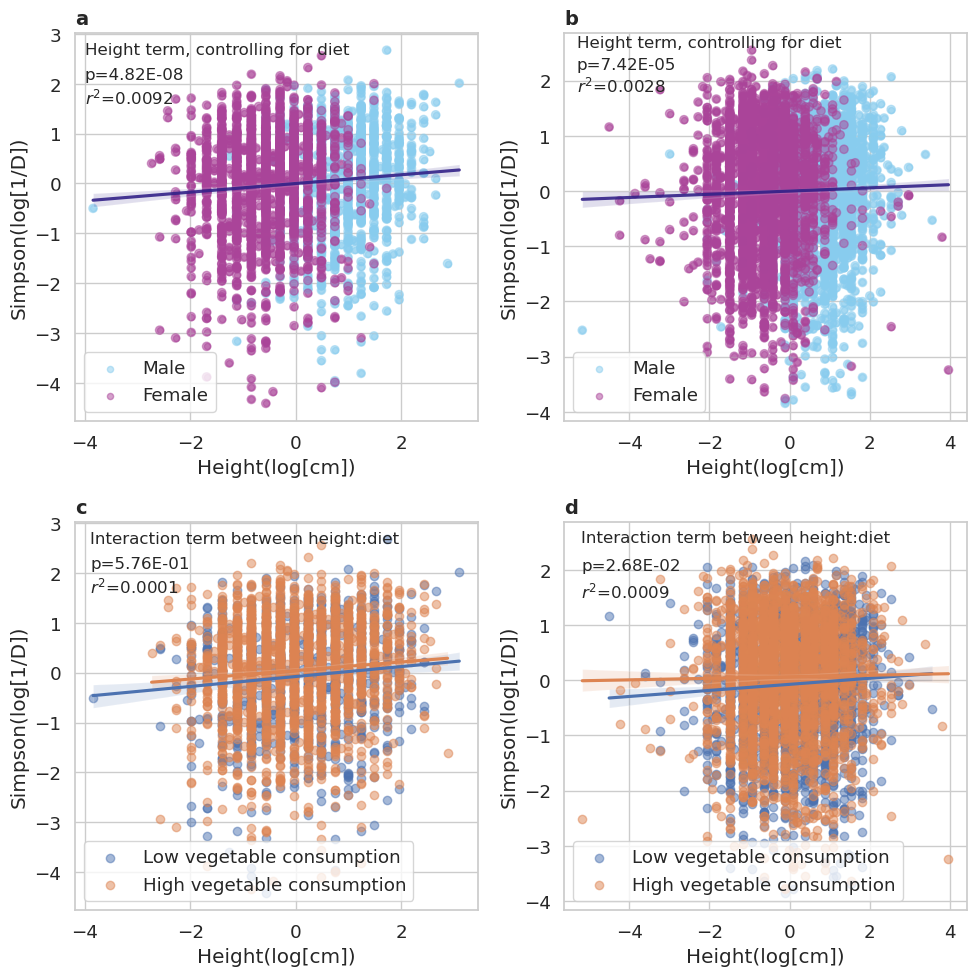

In [31]:
sns.set_theme(style='whitegrid',font_scale=1.2)
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout=True)

x = 'height_cm'
y = 'inv_simpson'

color_label = {'#88CCEE':'Male', '#AA4499':'Female'}
colors = ['#88CCEE','#AA4499']
labels = [color_label[x] for x in arivale['color'].unique()]

sns.regplot(data = arivale, ax = axs[0,0],
            x=x, y=y,scatter_kws={'c':arivale['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in arivale.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[0,0], zorder=0, alpha = 0.5, label=labels[index])
    index +=1

labels = [color_label[x] for x in amgut['color'].unique()]

sns.regplot(data = amgut, ax = axs[0,1],
            x=x, y=y,scatter_kws={'c':amgut['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in amgut.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[0,1], zorder=0, alpha = 0.5, label = labels[index])
    index +=1

axs[0,0].set(xlabel='Height(log[cm])',ylabel='Simpson(log[1/D])')
axs[0,0].text(-4, 2.6, 'Height term, controlling for diet', fontsize=12) 
axs[0,0].text(-4,2.1, f'p={arivale_height_p:.2E}', fontsize=12)
axs[0,0].text(-4,1.6,f'$r^2$={arivale_height_rsq:.4f}', fontsize=12)
axs[0,0].set_title('a', loc='left', fontsize=14, fontweight='bold')

axs[0,1].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])')
# axs[1].set_yticks([-4, -3, -2, -1, 0, 1, 2, 3])
axs[0,1].text(-5.3, 2.6, 'Height term, controlling for diet', fontsize=12)
axs[0,1].text(-5.3,2.2, f'p={amgut_height_p:.2E}', fontsize=12)
axs[0,1].text(-5.3,1.8,f'$r^2$={amgut_height_rsq:.4f}', fontsize=12)
axs[0,1].set_title('b', loc='left', fontsize=14, fontweight='bold')

x='height_cm'
y='inv_simpson'

sns.regplot(data=arivale[arivale['b_vegetable_frequency']=='low'], x=x, y=y, ax=axs[1,0], label='Low vegetable consumption',\
           scatter_kws={'alpha':0.5})
sns.regplot(data=arivale[arivale['b_vegetable_frequency']=='high'], x=x, y=y, ax=axs[1,0], label='High vegetable consumption',\
           scatter_kws={'alpha':0.5})


sns.regplot(data=amgut[amgut['b_vegetable_frequency']=='low'], x=x, y=y, ax=axs[1,1], label='Low vegetable consumption',\
            scatter_kws={'alpha':0.5})
sns.regplot(data=amgut[amgut['b_vegetable_frequency']=='high'], x=x, y=y, ax=axs[1,1], label='High vegetable consumption',\
           scatter_kws={'alpha':0.5}) 

axs[1,0].text(-3.9, 2.6, 'Interaction term between height:diet', fontsize=12)
axs[1,0].text(-3.9,2.1, f'p={arivale_interaction_p:.2E}', fontsize=12)
axs[1,0].text(-3.9, 1.6, f'$r^2$={arivale_interaction_rsq:.4f}', fontsize=12)

axs[1,1].text(-5.2, 2.5, 'Interaction term between height:diet', fontsize=12)
axs[1,1].text(-5.2,2, f'p={amgut_interaction_p:.2E}', fontsize=12)
axs[1,1].text(-5.2,1.5, f'$r^2$={amgut_interaction_rsq:.4f}', fontsize=12)
axs[1,0].set_title('c', loc='left', fontsize=14, fontweight='bold')
axs[1,1].set_title('d', loc='left', fontsize=14, fontweight='bold')

axs[1,0].legend(loc='lower left')
# axs[1,0].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])', ylim=(-6, 3))
axs[1,0].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])')
axs[1,1].legend(loc='lower left')
# axs[1,1].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])', ylim=(-6, 3))
axs[1,1].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])')

In [32]:
fig.savefig(genpath+'/output/all_human_cohort_diversity.pdf')
fig.savefig(genpath+'/output/all_human_cohort_diversity.png')